# Solution Notebook for ASTR 4260 PS#8

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn.tree as tree
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn import svm

Read in the RR Lyra dataset

In [2]:
def read_data(name):
    X = np.genfromtxt(name+'_features.txt', delimiter=',')
    Y = np.genfromtxt(name+'_labels.txt')
    return X, Y

name = "RRLyrae"
X, Y = read_data(name)

Let's characterize the data first

In [3]:
print('X, Y shapes:', X.shape, Y.shape)
print(len(Y))
print(X,Y)

X, Y shapes: (93141, 4) (93141,)
93141
[[ 0.39400032  1.25099932  0.13700032  0.06199932]
 [ 0.33900132  1.04800032  0.15199932  0.02300132]
 [ 0.34199932  1.00800132  0.12900032  0.20300132]
 ...
 [ 0.21200032  1.04400132  0.03500032  0.00200132]
 [ 0.17200132  1.06499932  0.04200032  0.00300032]
 [ 0.06500132  1.12599932 -0.01700032 -0.05799932]] [0. 0. 0. ... 1. 1. 1.]


It looks like the data may have been sorted.  Let's check whether that's true.

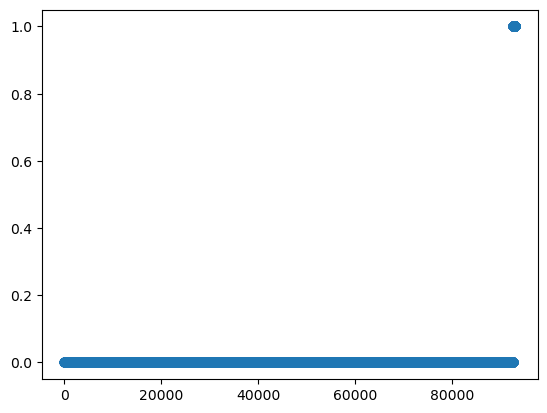

In [4]:
plt.scatter(range(len(Y)), Y)

So our training set has to include a fair sample of both kinds of stars.  Let's choose every fourth star to be the test set, and the rest to be the training set.  Note that the X array is two dimensional, so deletions have to be of whole rows.

test shape:  (23286, 4) train shape:  (69855, 4)


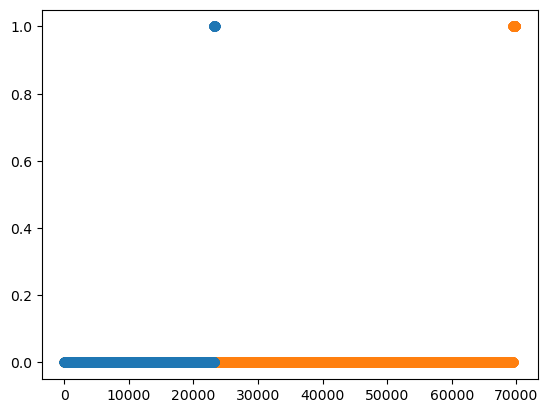

In [5]:
def split(X, Y, nsplit):
    Xtest = X[::nsplit, 0:4]
    Ytest = Y[::4]
    plt.scatter(range(len(Ytest)), Ytest, zorder=2)#make sure these points are on top

    Xtrain = np.delete(X,np.s_[::nsplit], axis = 0)     #delete points following this pattern using s_
    Ytrain = np.delete(Y,np.s_[::nsplit])   
    plt.scatter(range(len(Ytrain)), Ytrain, zorder=1)
    print('test shape: ', Xtest.shape, 'train shape: ', Xtrain.shape)
    return Xtest, Ytest, Xtrain, Ytrain

Xtest, Ytest, Xtrain, Ytrain = split(X, Y, 4)

# Problem 1: Decision Tree

Begin by setting up a classifier, and applying it to the training dataset, then plotting the result.

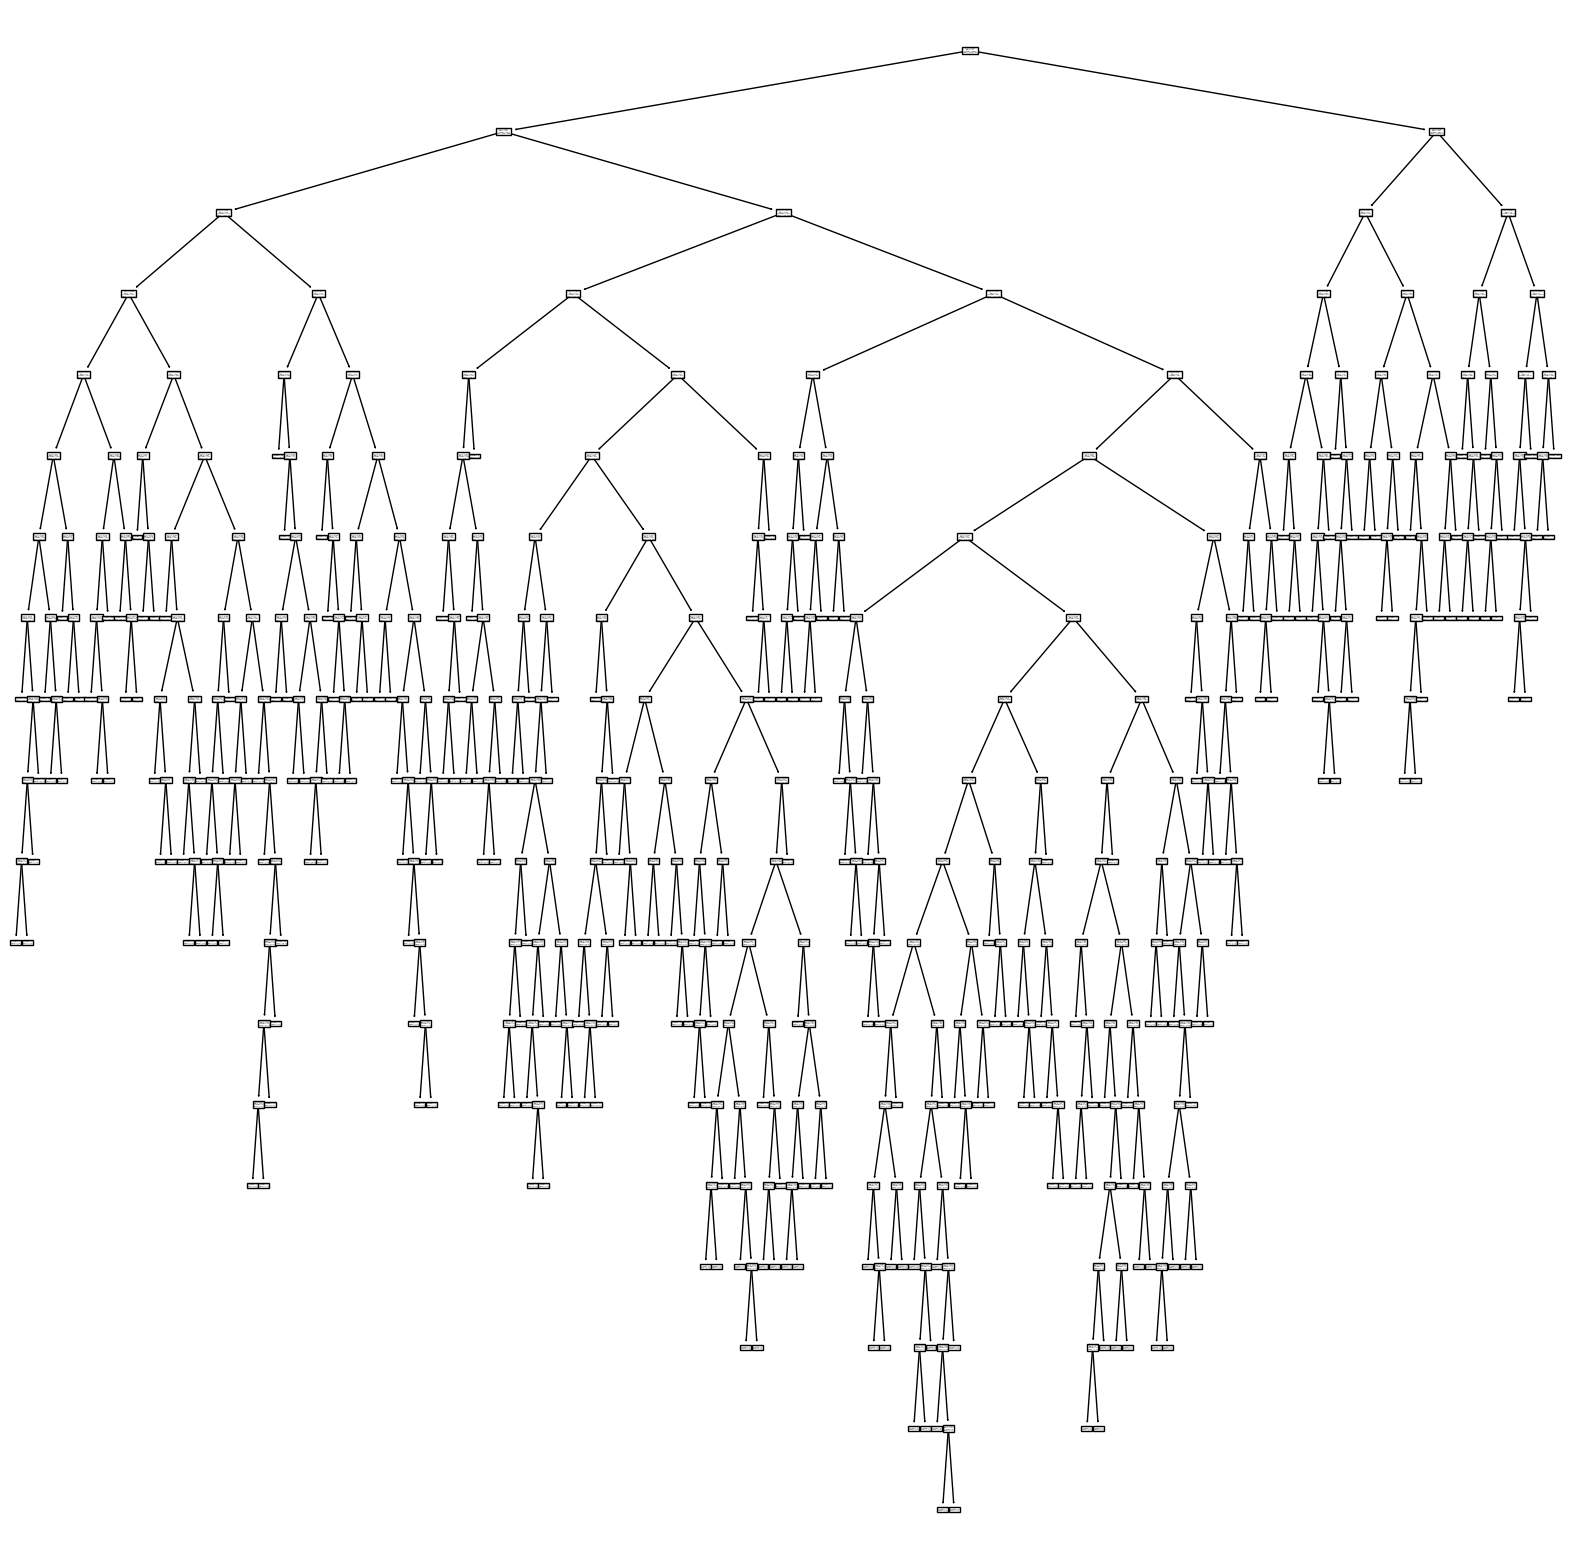

In [6]:
def dec_tree(Xtrain, Ytrain):
    dtree = tree.DecisionTreeClassifier()
    dtree = dtree.fit(Xtrain, Ytrain)
    plt.figure(figsize=(20,20))
    tree.plot_tree(dtree)
    plt.show
    return dtree

dtree = dec_tree(Xtrain, Ytrain)

That is a complex tree!  How well does it do?  There are a couple of different things we can test.  One is use cross_val_score, which compares multiple random subsamples of the full data set to each other.

In [7]:
cross_val_score(dtree, X, Y, cv=5)

array([0.99377315, 0.99463174, 0.99549066, 0.99602749, 0.99371913])

These look good but not necessarily great, given that RR Lyrae stars are a small fraction of the total.

What happens if we directly predict our test sample?

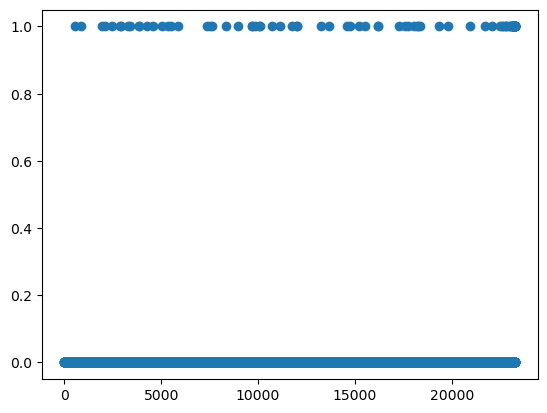

In [8]:
Yfit = dtree.predict(Xtest)
plt.scatter(range(len(Yfit)), Yfit )   #this is what was found

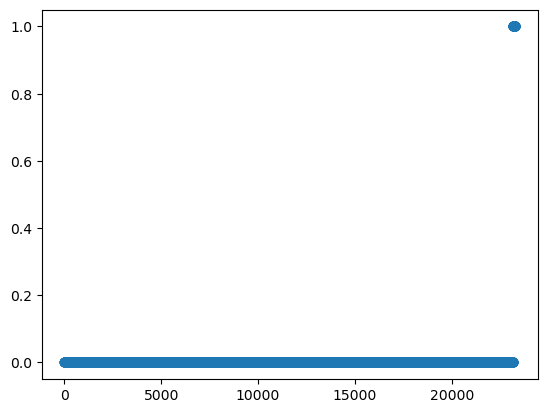

In [9]:
plt.scatter(range(len(Yfit)), Ytest) #this is what should have been found:

So there are many false positives!  There are probably also false negatives.  Let's find out how many of each.

In [10]:
def truth_table(Yfit, Ytest):
    '''print out a comparison between the fit and a test data set'''
    #print('test sample size: ',len(Yfit), '# of RR Lyrae stars: ',len(np.where(Ytest==1)[0]),'\n')

    RR_good = len(np.where(np.logical_and(Yfit == 1, Ytest == 1))[0])  #where returns a tuple whose first element 
    RR_bad  = len(np.where(np.logical_and(Yfit == 1, Ytest == 0))[0])  #is needed, so there's a final [0]
    MS_good = len(np.where(np.logical_and(Yfit == 0, Ytest == 0))[0])
    MS_bad  = len(np.where(np.logical_and(Yfit == 0, Ytest == 1))[0])

    label = ('good','bad')

    print('          ', f'{label[0]:>6}', f'{label[1]:>6}')
    print('RR Lyrae: ', f'{RR_good :6}', f'{RR_bad  :6}')
    print('  others: ', f'{MS_good :6}', f'{MS_bad  :6}')
    return

truth_table(Yfit, Ytest)

             good    bad
RR Lyrae:      72     62
  others:   23103     49


So, 71 of 121 RR Lyrae stars were discovered, but there were almost as many false detections (68), and 50 of the 121 RR Lyrae stars in the test set were missed (identified as other stars).

Let's take a look at the color space to see what the cuts are doing.  First we'll look at X[0] vs X[1], which is the top-level cut.

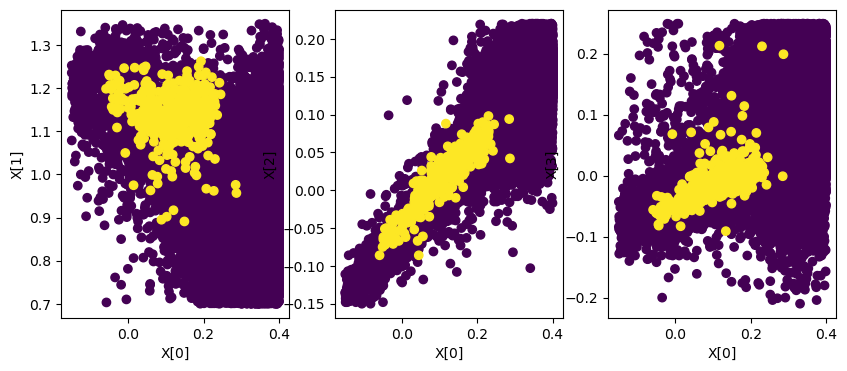

In [11]:
def plot_colors(X, Y):
    fig,ax = plt.subplots(1,3)
    fig.set_size_inches(10,4)

    ax[0].scatter(X[:,0],X[:,1],c=Y[:])
    ax[0].set_xlabel('X[0]')
    ax[0].set_ylabel('X[1]')

    ax[1].scatter(X[:,0],X[:,2],c=Y[:])
    ax[1].set_xlabel('X[0]')
    ax[1].set_ylabel('X[2]')

    ax[2].scatter(X[:,0],X[:,3],c=Y[:])
    ax[2].set_xlabel('X[0]')
    ax[2].set_ylabel('X[3]')

    plt.show()
    
plot_colors(X, Y)

Would reducing the depth of the decision tree improve or damage performance?

In [12]:
def tree_depth(Xtrain, Xtest, Ytrain, Ytest, depth = 3, bal = None):
    dtree = tree.DecisionTreeClassifier(max_depth=depth, class_weight = bal)  #we'll use class_weight later
    dtree = dtree.fit(Xtrain, Ytrain)
    Yfit = dtree.predict(Xtest)
    truth_table(Yfit, Ytest)
    
    scores = cross_val_score(dtree, np.concatenate((Xtrain,Xtest)), np.concatenate((Ytrain,Ytest)), cv=5)
    print('\ncross validation scores: ', scores)
    
tree_depth(Xtrain, Xtest, Ytrain, Ytest)

             good    bad
RR Lyrae:       0      0
  others:   23165    121

cross validation scores:  [0.99479306 0.99484647 0.99484647 0.99479279 0.99479279]


The cross validation scores look great, but no RR Lyrae stars were actually found.  This emphasizes the limitation of relying on cross validation scores when looking for rare objects.

In [13]:
def depth_series(Xtrain, Xtest, Ytrain, Ytest, bal = None):
    for i in range(3,10):
        print('max_depth = ',i, '\n')
        tree_depth(Xtrain, Xtest, Ytrain, Ytest, depth = i, bal = bal)
        print('\n')
        
depth_series(Xtrain, Xtest, Ytrain, Ytest)

max_depth =  3 

             good    bad
RR Lyrae:       0      0
  others:   23165    121

cross validation scores:  [0.99479306 0.99484647 0.99484647 0.99479279 0.99479279]


max_depth =  4 

             good    bad
RR Lyrae:      77     74
  others:   23091     44

cross validation scores:  [0.99484674 0.99479279 0.99640326 0.99355808 0.99554434]


max_depth =  5 

             good    bad
RR Lyrae:      78     70
  others:   23095     43

cross validation scores:  [0.99463203 0.99425596 0.99694009 0.99404123 0.99581275]


max_depth =  6 

             good    bad
RR Lyrae:      68     52
  others:   23113     53

cross validation scores:  [0.99538354 0.99463174 0.99667168 0.99452437 0.99581275]


max_depth =  7 

             good    bad
RR Lyrae:      72     56
  others:   23109     49

cross validation scores:  [0.99592034 0.99543698 0.99661799 0.9947391  0.99575907]


max_depth =  8 

             good    bad
RR Lyrae:      75     70
  others:   23095     46

cross validation 

Once a maximum depth of 5 has been reached, overfitting appears to set in.

Now let's try balanced weighting here. This means weighting by the inverse of frequency, so very heavily weighting the rare RR Lyrae stars.

In [14]:
depth_series(Xtrain, Xtest, Ytrain, Ytest, bal = 'balanced')   #bal is passed to the class_weight parameter

max_depth =  3 

             good    bad
RR Lyrae:     121    869
  others:   22296      0

cross validation scores:  [0.97299909 0.973105   0.97181662 0.96698518 0.97170925]


max_depth =  4 

             good    bad
RR Lyrae:     117    648
  others:   22517      4

cross validation scores:  [0.97391164 0.97369551 0.97632596 0.96945458 0.97353446]


max_depth =  5 

             good    bad
RR Lyrae:     117    603
  others:   22562      4

cross validation scores:  [0.97992377 0.97659437 0.9774533  0.97127979 0.97750698]


max_depth =  6 

             good    bad
RR Lyrae:     116    518
  others:   22647      5

cross validation scores:  [0.98126577 0.98008374 0.97895641 0.97756066 0.97890273]


max_depth =  7 

             good    bad
RR Lyrae:     114    465
  others:   22700      7

cross validation scores:  [0.98180257 0.98207    0.98142581 0.9799227  0.98190895]


max_depth =  8 

             good    bad
RR Lyrae:     113    444
  others:   22721      8

cross validation 

This was far more effective at identifying RR Lyrae stars! At `depth = 3`, all of them were found, though at the cost of seven times as many false positives.  At `depth = 9`, there were less than four times as many false positives, and only 7% of RR Lyrae stars were missed. One of these classifiers would be a useful tool for focusing observational effort: reducing the problem from having to take spectra of 23,000 stars to 400 stars is a significant advance.   Note that the cross-val scores have dropped, and yet we might find this to be a more useful tool.

# Problem 2: Support Vector Machine

Let's try out a polynomial kernel support vector machine (SVM) from scikit-learn (with the default polynomial degree of 3.)

In [15]:

def svm_test(test_svm):
    '''A routine to fit and test an SVM with specific parameters.'''
    test_svm.fit(Xtrain, Ytrain)

    Yfit_test = test_svm.predict(Xtest)
    truth_table(Yfit_test, Ytest)
    
    scores = cross_val_score(test_svm, np.concatenate((Xtrain,Xtest)), np.concatenate((Ytrain,Ytest)), cv=5)
    print('\ncross validation scores: ', scores)
    return


poly_svm=svm.SVC(kernel='poly')
svm_test(poly_svm)

             good    bad
RR Lyrae:       0      0
  others:   23165    121

cross validation scores:  [0.99479306 0.99484647 0.99484647 0.99479279 0.99479279]


Although we got good cross-validation scores, no RR Lyrae stars were identified!

Does the default radial basis function (rbf) SVM work any better?

In [16]:
rbf_svm=svm.SVC()
svm_test(rbf_svm) 

             good    bad
RR Lyrae:       0      0
  others:   23165    121

cross validation scores:  [0.99479306 0.99484647 0.99484647 0.99479279 0.99479279]


No, really not!  

Let's try weighting the RR Lyrae stars more heavily than the others using the argument class_weight = 'balanced', which weights the classes inversely to frequency. 

In [17]:
rbf_balanced_svm=svm.SVC(class_weight = 'balanced')
svm_test(rbf_balanced_svm)

             good    bad
RR Lyrae:     120    723
  others:   22442      1

cross validation scores:  [0.97154973 0.97085033 0.97213872 0.96623363 0.96741464]


Well, that was _highly_ successful in finding RR Lyrae stars, at the cost of generating lots of false positives. 

What happens if we try a polynomial kernel with balanced weights?

In [18]:
poly_balanced_svm = svm.SVC(kernel = 'poly', class_weight = 'balanced')
svm_test(poly_balanced_svm)

             good    bad
RR Lyrae:     121    724
  others:   22441      0

cross validation scores:  [0.9711203  0.97154821 0.96886408 0.96515997 0.96703887]


This is 100% successful at finding the RR Lyrae stars in our test set, at the cost of six times as many false positives (more than the decision tree by a modest factor).  Again, this would still be a useful tool for focusing observational effort.  

Note that even though this identifies RR Lyrae stars, the false positives push down the cross validation scores compared to the completely ineffective SVMs that I started with.  Thus, one needs to carefully consider the actual use case for the classifier, and not simply rely on cross-validation scores to determine the effectiveness of the classifier.